## Text Embedding-Driven Analysis of Crease's Stances Towards Chinese Immigrants with Evidence from Legal Cases

### Learning Objectives

In this notebook, you will:

1. Explore legal texts in a visual and interactive way through text embeddings.
2. Learn how computers can process and analyze texts with pre-trained models.
3. Understand how to create word embeddings, sentence embeddings, and use them to capture the underlying semantic and contextual meaning of texts.
4. Using a comparative approach to analyze the stance of Crease towards Chinese immigrants in British Columbia.
5. Critically reflect on the limitations of text embeddings in historical analysis.

### Pre-requisites

1. Finished the assigned readings including the Chinese Regulation Act of 1884 and the two legal cases.
2. Familiar with the basic concepts of text embeddings and how they are used in natural language processing (NLP). If you are not familiar with these concepts, pleaser read [Introduction to Text Embeddings]().
3. Familiar with the basic concepts of cosine similarity and how it is used to measure the similarity between two vectors. If you are not familiar with these concepts, please read [Introduction to Cosine Similarity]().

Before you start, make sure you have the required libraries installed, if not, **uncomment the lines below (i.e. remove the #) and run the cell to install them**: 

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pup install plotly
# !pip install sklearn
# !pip install torch
# !pip install transformers
# !pip install umap-learn

### Introduction

Among all techniques, **text embeddings** have emerged as a powerful tool for analyzing texts and their underlying meanings. Text embeddings are numerical representations of words, sentences, or documents that capture their semantic and contextual meanings. They allow us to analyze texts in a more efficient and effective way, enabling us to uncover patterns and relationships that may not be immediately apparent.

Studying legal texts can be a challenging task for historians, especially when it comes to analyzing the stance of historical figures towards specific groups or certain events only based on legal discourse. Text embeddings can potentially help us to overcome this challenge by providing a way to analyze the texts in a more nuanced and sophisticated manner.

In this notebook, we will focus on the ***Regina V Wing Chong (1885)***-- a legal case in British Columbia that pronounced the Chinese Regulation Act of 1884 unconstitutional-- to analyze the stance of Crease towards Chinese immigrants in British Columbia, while introducing the concept and application of text embeddings. We also encourage you to discuss the results you see and critically reflect on the limitations of text embeddings in historical analysis. Hopefully, this will inspire you to think about how machine learning can be used to analyze other historical texts and uncover the underlying meanings and relationships within them.

### Data Exploration

#### Data Preparation

To begin our analysis, we collected a dataset of 10 documents related to Chinese immigrants problems in British Columbia, Canada, specifically focusing on the legal cases involving Justice Crease, including *Regina V Wing Chong (1885)*, *Wong Hoy Woon V Duncan (1894)* and his answer to the inquiry at the Royal Commission on Chinese Immigrants in 1885. For comparison, we also included legal cases involving other judges such as Justice Begbie and Justice Fitzpatrick, and other reports made at the Royal Commission on Chinese Immigrants. Among which, we focus on Begbie as a reference level for comparison, as he was known for his more lenient stance towards Chinese. We also included the original text of the *Chinese Regulation Act, 1884* as another reference level for comparison, as it was a significant piece of discriminatory legislation against Chinese immigrants in British Columbia.

We prepared our dataset using a technique called **Optical Character Recognition (OCR)** to convert scanned legal documents into machine-readable text. This process involved several steps: 

1. Finding the scanned documents from sources such as the Law Society of British Columbia Court Report and Canadian Legal Information Institute. 
2. We used OCR models such as [Nanonets OCR](https://huggingface.co/nanonets/Nanonets-OCR-s) and [Azure AI Vision](https://azure.microsoft.com/en-us/products/ai-services/ai-vision) to extract text from these scanned images, ensuring that the text was as accurate as possible through prompt tuning and script optimization. 
3. We cleaned the extracted text manually to remove any artifacts or errors introduced during the OCR process. 

However, due to the nature of OCR, some errors may still persist, which we acknowledge as a limitation of our dataset, and we welcome contributions to improve the dataset.

#### Dataset Reading

After preparing the dataset, we read the documents as below using the `pandas` library in Python. It is in a tabular format with columns for the filename, author, type of the document and text content. To refine our analysis, we also removed direct quotations of the *Chinese Regulation Act, 1884* in other documents to avoid bias. The number of quotes sentences removed is also recorded in the dataset. 

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../data/metadata_cleaned.csv")

df

,filename,author,type,text,act_quote_sentences_removed
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...",12
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...",0
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...,0
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...",0
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...,0
5,commission_on_chinese_imigration.txt,Powell,report,"On the 4th of July, 1884, the following Commis...",0
6,chapleau_report_resume.txt,Chapleau,report,RESUMÉ.\r\n\r\n1. That Chinese labor is a most...,0
7,crease_commission.txt,Crease,report,"The Hon. Mr. Justice CREASE, Judge of the Supr...",0
8,begbie_commission.txt,Begbie,report,"Sir MATTHEW BEGBIE, Chief Justice of British C...",0
9,chinese_regulation_act_1884.txt,Others,act,An Act to regulate the Chinese population of B...,0


Each document's length, measured by the number of characters, is displayed below for reference.

In [3]:
# Summary the distribution of document lengths
# Create a DataFrame to store the document lengths
doc_lengths = []

for row in df.iterrows():
    text_length = len(row[1]['text'])
    doc_lengths.append({'Document': row[1]['filename'], 'Length': text_length})

# Convert to DataFrame and display
doc_lengths_df = pd.DataFrame(doc_lengths)
print(doc_lengths_df)


                               Document  Length
0               regina_v_wing_chong.txt   41337
1            wong_hoy_woon_v_duncan.txt   13912
2                  regina_v_mee_wah.txt   25114
3                 regina_v_victoria.txt    8252
4             quong_wing_v_the_king.txt   46982
5  commission_on_chinese_imigration.txt    3402
6            chapleau_report_resume.txt   10906
7                 crease_commission.txt   30766
8                 begbie_commission.txt   41270
9       chinese_regulation_act_1884.txt   12908


### Word Embedding Analysis Using LEGAL-BERT

The model we are using for creating the text embeddings is **[LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased)**, it is a model trained on 12 GB of diverse English legal texts, including case law, legislation, and contracts and designed to capture the legal language and concepts. It is based on the **BERT architecture**, which is a transformer-based model that has been shown to be effective for various natural language processing tasks.

The first thing we want to do is to create word embeddings for our full corpus, which is a collection of all the text documents in our dataset. Creating word embeddings on the full corpus allows us to capture the overall semantic meaning of the text as perceived by the model and find the most similar words to a given word in the corpus. This is useful for understanding the general context and meaning of the text, as well as for finding related terms that may not be explicitly mentioned in the text.

We begin by removing punctuations from the text and join the text into a single string. This is done to ensure that the model can process the text correctly and to avoid any issues with punctuation marks that may affect the word embeddings.

In [4]:
# Define a function to clean the text
import re

def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    return text.strip()

We use the `word_tokenize` module from `nltk` library to tokenize the full text into a list of words. This step is crucial for preparing the text for the model, as it allows us to analyze the individual words and their relationships within the text.

In [5]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

# Create the large corpus by joining all text from all authors
all_text = " ".join(df["text"].tolist())

clean_text = clean_text(all_text)

# Tokenize the cleaned text into words
words = word_tokenize(clean_text)

# Tokenize the cleaned text into sentences
sentences = sent_tokenize(all_text.lower())

Then we load the LEGAL-BERT model and tokenizer from the Hugging Face library. The **tokenizer** is used to convert the text into a format that the model can understand, while the model itself is used to generate the word embeddings. And the model is set to evaluation mode to ensure that it does not perform any training or updates during the embedding generation process.

In [6]:
# Load the tokenizer and model from Hugging Face
from transformers import AutoTokenizer, AutoModel
import torch

# We will use the Legal-BERT model for this task
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
model = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased').eval() # set the model to evaluation mode

The next step allows us to see how many unique words are present in the corpus.

In [7]:
# Create the word embeddings
# Get unique words to avoid redundant computation
unique_words = list(set(words))

# Print the shape of unique tokens
print(f'There are {len(unique_words)} unique tokens in this corpus.')

There are 4889 unique tokens in this corpus.


Finally, we generate the word embeddings. The embeddings are generated by passing the **sentence tokenized** (broken into sentence units) text through the model, which produces a tensor of embeddings for each word in the text. And we average the embeddings for each word to create a single embedding vector that represents the word's meaning in the context of the corpus, so that the embeddings for each word will capture the overall semantic meaning of the word as it appears in the text.

We also create a **dictionary** to store the unique words and their embeddings. The keys of the dictionary are the words themselves, and the values are the corresponding embeddings generated by the model. This allows us to easily access and analyze the embeddings for any specific word in our corpus.

In [8]:
from collections import defaultdict
# Use a defaultdict to store lists of embeddings for each word
by_word = defaultdict(list)

for sent in sentences:
    tokens = tokenizer.tokenize(sent)
    inputs = tokenizer.encode_plus(sent, 
                                   return_tensors='pt',
                                   truncation=True,
                                   max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.squeeze(0)  
    # Map WordPiece tokens back to words
    wp_to_word = []
    curr_word = ""
    for idx, piece in enumerate(tokens):
        if piece.startswith("##"):
            curr_word += piece[2:]
        else:
            if curr_word:
                wp_to_word.append(curr_word)
            curr_word = piece
        # whenever next token isn't a continuation, close the word
        next_is_cont = (idx+1 < len(tokens) and tokens[idx+1].startswith("##"))
        if not next_is_cont:
            wp_to_word.append(curr_word)
            curr_word = ""
            
    # align embeddings
    emb_idx = 1
    word_idx = 0
    while emb_idx < outputs.shape[0] and word_idx < len(wp_to_word):
        # find how many WordPieces form this word
        word = wp_to_word[word_idx]
        # sum/avg the pieces for that word
        piece_embs = [outputs[emb_idx]]
        emb_idx += 1
        # if next piece token starts with "##", keep adding
        while emb_idx < outputs.shape[0] and tokenizer.convert_ids_to_tokens(int(inputs["input_ids"][0, emb_idx])).startswith("##"):
            piece_embs.append(outputs[emb_idx])
            emb_idx += 1
            
        word_emb = torch.stack(piece_embs, dim=0).mean(dim=0).cpu().numpy()
        by_word[word].append(word_emb)
        word_idx += 1
 
# Average the embeddings for each word       
word_embeddings = {
    w: np.mean(np.stack(embs, axis=0), axis=0)
    for w, embs in by_word.items()
}

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The **embedding** of each word is a list of numbers that represents the word in a high-dimensional space, capturing its semantic meaning and relationships with other words. Below is an example of the embedding for the word "Chinese", we only display the first 20 dimensions of the embedding for brevity:

In [9]:
# Print embedding for the word of interest 'chinese'
print(f"First 20 dimensions of the embedding for 'chinese':\n{word_embeddings.get('chinese')[:20]}") # Display first 20 dimensions of the embedding

First 20 dimensions of the embedding for 'chinese':
[ 0.13301814  0.31348336  0.13036042  0.06170142  0.34849504  0.11123911
  0.12078131  0.23966664 -0.2801064  -0.12666991  0.04423679  0.4812117
  0.00927597 -0.07745101 -0.43305182  0.22666645  0.1506961  -0.11196993
 -0.6293698   0.39736295]


But in fact, LEGAL-BERT generates a 768-dimensional embedding for each word, as we can see below:

In [10]:
print(f"The dimension of the embedding is {len(word_embeddings['chinese'])}")

The dimension of the embedding is 768


We want to see what words are most similar to the word "Chinese" in our corpus. To do this, we calculate the cosine similarity between the embedding of "Chinese" and the embeddings of all other words in the corpus. The cosine similarity is a measure of similarity between two vectors, and it ranges from 0 (completely not similar) to 1 (completely similar). We then sort the words by their cosine similarity to "Chinese" and display the top 10 most similar words.

In [11]:
# Compute cosine similarity between all words with Chinese in the model
from scipy.spatial.distance import cosine

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinese":
        similarity = 1 - cosine(word_embeddings["chinese"], word_embeddings[other_word]) # 1 - cosine distance gives cosine similarity
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinese':")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinese':
chinaman: 0.8710
china: 0.8701
chinamen: 0.8674
japanese: 0.8392
white: 0.8351
immigrant: 0.8290
whites: 0.8182
alien: 0.8181
europeans: 0.8104
immigrants: 0.8102


With the same approach, we can also find the top 10 most similar words to "Chinaman", which is also frequently used in the corpus to refer to Chinese immigrants at the time.

In [12]:
# Compute cosine similarity between all words with Chinaman in the model

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinaman":
        similarity = 1 - cosine(word_embeddings["chinaman"], word_embeddings[other_word])
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinaman'")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinaman'
chinamen: 0.9387
leper: 0.8949
washerman: 0.8946
countrymen: 0.8760
man: 0.8736
chinese: 0.8710
europeans: 0.8658
lepers: 0.8535
compradors: 0.8413
oriental: 0.8402


It is hard to understand how the embeddings are distributed in the high-dimensional space, but we can visualize the embeddings using **dimensionality reduction** techniques such as **t-SNE** (t-distributed Stochastic Neighbor Embedding) or **UMAP** (Uniform Manifold Approximation and Projection). These techniques allow us to reduce the dimensionality of the embeddings while preserving their relationships, making it easier to visualize and interpret the data. 

Below is an interactive visualization of the embeddings using **t-SNE** with the embeddings of "Chinese", "China", "Chinaman" and "Chinamen" labeled in the plot. Play with the plot to see what patterns you can find in the embeddings.

In [13]:
# Generate a t-SNE plot for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)

embeddings = np.array(list(word_embeddings.values()))
tsne_results = tsne.fit_transform(embeddings)

In [14]:
# Create a DataFrame for visualization
import plotly.express as px

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['word'] = list(word_embeddings.keys())
# Highlight the word 'chinese' in the plot
keywords = ["chinese", "china", "chinaman", "chinamen"]
df_tsne['highlight'] = df_tsne['word'].apply(lambda x: x if x in keywords else '')

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    title='t-SNE Visualization of legal-BERT Word Embeddings',
    color='highlight',                        
    hover_data=['word'], 
    text= 'highlight',
    height=600,
    width=800
)

fig.show()

> **Discussion:**
>
> - Based on your reading of the original text documents, do you think the word embeddings generated by LEGAL-BERT accurately capture the meaning and context of the words in the corpus? 
> - Are there any specific words or phrases that you think should be included in the embeddings to better represent the legal language and concepts in the text?

### Text Embedding and Analysis of Crease and Begbie Corpus Including Their Reports at the Royal Commission on Chinese Immigrants

The first comparison that we really want to make is between Justice Crease and Justice Begbie, as they are both significant figures in the history of BC law. We want to see how they are similar or different in their stances towards Chinese immigrants, and how their language reflects their attitudes. 

For this comparison, we will use the corpora including both their legal cases involving Chinese immigrants and their reports at the Royal Commission on Chinese immigrants. 

In [15]:
# Compile the Crease texts into a single text list
crease_texts = df[df['author'] == 'Crease']['text'].tolist()

# Compile the Begbie texts into a single text list
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()

# Combine both lists in a dictionary
judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts
}

Since we are more interested in the stance contained in sentences, here we will use **sentence embeddings** instead of word embeddings. Sentence embeddings are a way to represent entire sentences as vectors in a high-dimensional space, capturing the semantic meaning of the sentence as a whole. This is particularly useful for comparing the overall meaning and sentiment of different sentences, rather than just individual words.

We will use the same LEGAL-BERT model to generate sentence embeddings, with a customized approach to handle the text data. What I will do is to create a function that takes a list of sentences as input, focusing on the selected "keywords" that we want to analyze and the "window" around it to detect the context of the keywords. The function will then generate embeddings for each sentence in the list. 

With this approach, we can effectively capture the context and meaning of the sentences in relation to the keywords, which is crucial for understanding the stances of Justice Crease and Justice Begbie. 

In [16]:
# Define a function to embed text using the model
from typing import Union, List

def embed_text(
    text,
    focus_token= None,
    window = 10,
    pooling = "mean",  # "mean" (default), "max", or "min"
    tokenizer=tokenizer,
    model=model):

    # Run the model once
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state.squeeze(0) 

    if focus_token is None:
        return hidden[0].cpu().numpy()
    
    # Normalize to list
    keywords = (
        [focus_token] if isinstance(focus_token, str)
        else focus_token
    )

    # Pre-tokenize each keyword to its subtoken ids
    kw_token_ids = {
        kw: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(kw))
        for kw in keywords
    }

    input_ids = inputs["input_ids"].squeeze(0).tolist()
    spans = []  # list of (start, end) index pairs

    # find every match of every keyword
    for kw, sub_ids in kw_token_ids.items():
        L = len(sub_ids)
        for i in range(len(input_ids) - L + 1):
            if input_ids[i:i+L] == sub_ids:
                spans.append((i, i+L))

    if not spans:
        # fallback on CLS vector
        return hidden[0].cpu().numpy()

    # For each span, grab the window around it
    vecs = []
    for (start, end) in spans:
        lo = max(1, start - window)
        hi = min(hidden.size(0), end + window)
        # mean‑pool over all tokens in this extended window
        span_vec = hidden[lo:hi]
        
        if pooling == "mean":
            pooled = span_vec.mean(dim=0)
        elif pooling == "max":
            pooled = span_vec.max(dim=0).values
        elif pooling == "min":
            pooled = span_vec.min(dim=0).values
        else:
            raise ValueError(f"Unknown pooling method: {pooling}")
        
        vecs.append(pooled.cpu().numpy())

    # Average across all spans
    return np.mean(np.stack(vecs, axis=0), axis=0)

We then define a list of keywords that we want to focus on in our analysis. These keywords are either the direct mentions of "Chinese" and "Chinaman" or related terms such as "immigrant" and "alien". We will use these keywords to filter the sentences that we want to analyze, ensuring that we capture the relevant context and meaning of the sentences in relation to the keywords.

Then we create a dictionary to hold the filtered sentences for each author and construct a snippets of sentences that contain the keywords. This allows us to focus on the specific sentences that are relevant to our analysis, rather than analyzing the entire text of each document.

In [17]:
from nltk import sent_tokenize 
# Create a dictionary to hold the mentionings of "Chinese" by author
judge_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen", "immigrant", "immigrants", "immigration", "alien", "aliens"]
for auth, texts in judge_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    judge_snippets[auth] = snippets

In [18]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in judge_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")
    

Snippet size by author:
Crease: 151
Begbie: 109


We also create a list to hold the names of other ethnicities that we want to use as a reference. We embed this list of ethnicities using the same embedding function and average the embeddings to create an "ethnicity anchor". This anchor will be used to compare how much the ethnicity factors are contributing to the stance of the judges.

In [19]:
# Define an ethnicity anchor, not including "chinese"
ethnicities = [
    "Japanese",   "Korean",    "Vietnamese",
    "Filipino",    "Thai",       "Malay",     "Indian",
    "Pakistani",   "Bangladeshi","Nepalese",  "Tibetan",
    "Arab",        "Persian",    "Turkish",   "Slavic",
    "Germanic",    "Celtic",     "Slavic",    "Romani",
    "Jewish",      "Zulu",       "Xhosa",     "Maori",
    "Sami",        "Berber",     "Tamil",     "Punjabi",
    "Bengali",     "Kazakh",     "Uyghur"
]

# Create embeddings
eth_vecs = []
for e in ethnicities:
    eth_vecs.append(embed_text(e))
    
eth_anchor = np.mean(eth_vecs, axis=0)

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



Then, it is time to create the embeddings for the snippets of sentences that we have filtered. We apply the same embedding function to the snippets of each judge, respectively. We store the embeddings in a dictionary, where the keys are the authors and the values are lists of embeddings for each snippet.

In [20]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, snippets in judge_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v)


We also create a dictionary to hold the embeddings of both judges subtracting the ethnicity anchor. This allows us to compare the stances of the judges controlling for the ethnicity factor.

In [21]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

Our way of comparing the cosine similarity between the embeddings of the snippets is to take the mean of the embeddings for each judge and then calculate the cosine similarity between the mean embeddings. This gives us a measure of how similar the stances of the judges are on average.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute per author mean and cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)  
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0] 

print(f"Cosine similarity between mean Crease and mean Begbie: {sim_crease_begbie:.4f}")

Cosine similarity between mean Crease and mean Begbie: 0.9947


We can also compare the cosine similarities between the two mean embeddings with ethnicity anchor removed. This allows us to see if the ethnicity factor is contributing positively or negatively to the stances of the judges.

In [23]:
# Compute per author mean and cosine similarity
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)  
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0] 

print(f"Cosine similarity between mean Crease and mean Begbie with ethical axis removed: {sim_crease_begbie_sub:.4f}")

Cosine similarity between mean Crease and mean Begbie with ethical axis removed: 0.9970


We can also calculate the cosine similarity between the max embeddings of the snippets for each judge. This gives us a measure of how similar the most extreme stances of the judges are. Similarly, the cosine similarity between the min embeddings of the snippets for each judge can be calculated to see how similar the least extreme stances of the judges are.

In [24]:
# We check the cosine similarity of max and min embeddings
max_crease = np.max(embeddings_dict["Crease"], axis=0, keepdims=True)
min_crease = np.min(embeddings_dict["Crease"], axis=0, keepdims=True)
max_begbie = np.max(embeddings_dict["Begbie"], axis=0, keepdims=True)
min_begbie = np.min(embeddings_dict["Begbie"], axis=0, keepdims=True)

sim_crease_begbie_max = cosine_similarity(max_crease, max_begbie)[0, 0]
sim_crease_begbie_min = cosine_similarity(min_crease, min_begbie)[0, 0]

print(f"Cosine similarity between max Crease and max Begbie: {sim_crease_begbie_max:.4f}")
print(f"Cosine similarity between min Crease and min Begbie: {sim_crease_begbie_min:.4f}")

Cosine similarity between max Crease and max Begbie: 0.9782
Cosine similarity between min Crease and min Begbie: 0.9832


Finally, we calculate the the cosine similarities between all the embeddings of the snippets for Crease and Begbie, and take the mean of the cosine similarities to get a measure of how similar the stances of the two judges are across all snippets. This gives us a more comprehensive understanding of the overall similarity between the two judges' stances towards Chinese.

In [25]:
# Extract embeddings for Crease and Begbie
crease_embeddings = embeddings_dict["Crease"]
begbie_embeddings = embeddings_dict["Begbie"]

# Calculate cosine similarity for all pairs of embeddings
similarities = []
for emb1 in crease_embeddings:
    for emb2 in begbie_embeddings:
        similarity = 1 - cosine(emb1, emb2) 
        similarities.append(similarity)

# Calculate the mean of all similarities
mean_similarity = sum(similarities) / len(similarities)

print(f"Mean cosine similarity between Crease and Begbie embeddings: {mean_similarity:.4f}")

Mean cosine similarity between Crease and Begbie embeddings: 0.8660


We can also resample with replacement to get a **confidence interval** for the cosine similarity. This allows us to see how robust the similarity measure is and how much it varies across different samples of the data.

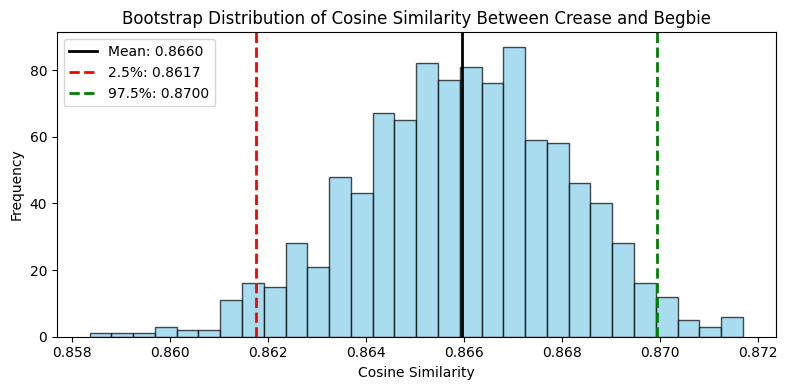

Bootstrap mean cosine similarity between Crease and Begbie: 0.8660
95% Confidence Interval: [0.8617, 0.8700]


In [ ]:
import matplotlib.pyplot as plt

# We can bootstrap the similarity score to get a confidence interval
def compute_mean_similarity(sample1, sample2):
    similarities = []
    for emb1 in sample1:
        for emb2 in sample2:
            similarity = 1 - cosine(emb1, emb2)
            similarities.append(similarity)
    return np.mean(similarities)

# Bootstrap using manual resampling approach
n_boot = 500
cosine_scores = []

for _ in range(n_boot):
    # Resample with replacement
    crease_sample = np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)
    begbie_sample = np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)
    
    # Get the resampled embeddings
    crease_resampled = [crease_embeddings[i] for i in crease_sample]
    begbie_resampled = [begbie_embeddings[i] for i in begbie_sample]
    
    # Compute mean similarity for this bootstrap sample
    mean_sim = compute_mean_similarity(crease_resampled, begbie_resampled)
    cosine_scores.append(mean_sim)

cosine_scores = np.array(cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(cosine_scores, 2.5)
upper = np.percentile(cosine_scores, 97.5)
mean_sim = np.mean(cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

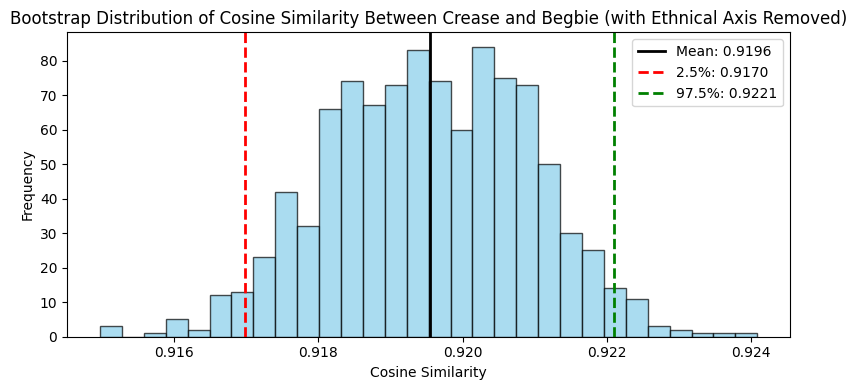

Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: 0.9196
95% Confidence Interval: [0.9170, 0.9221]


In [27]:
# Similarly, bootstrap the similarity score to get a confidence interval
crease_embeddings = np.array(subtracted_embeddings_dict["Crease"])
begbie_embeddings = np.array(subtracted_embeddings_dict["Begbie"])

# Convert to arrays
crease_embeddings = np.vstack(crease_embeddings)
begbie_embeddings = np.vstack(begbie_embeddings)

n_boot = 500
subtracted_cosine_scores = []

for _ in range(n_boot):
    # Sample with replacement
    crease_sample = crease_embeddings[np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)]
    begbie_sample = begbie_embeddings[np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)]
    
    # Compute cosine similarity for all pairs of sampled embeddings
    similarities = []
    for emb1 in crease_sample:
        for emb2 in begbie_sample:
            similarity = 1 - cosine(emb1, emb2) 
            similarities.append(similarity)
    
    # Compute mean similarity
    cos_sim = np.mean(similarities)
    subtracted_cosine_scores.append(cos_sim)


# Convert to numpy array
subtracted_cosine_scores = np.array(subtracted_cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(subtracted_cosine_scores, 2.5)
upper = np.percentile(subtracted_cosine_scores, 97.5)
mean_sim = np.mean(subtracted_cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(subtracted_cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie (with Ethnical Axis Removed)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

We use a **t-test** to see if the ethnicity factor is contributing significantly to the stances of the judges. The t-test compares the means of the mean cosine similarities with and without the ethnicity anchor removed. If the p-value is less than 0.05, we can conclude that the difference is statistically significant, indicating that the stance of the judges is significantly influenced by their underlying ethnic biases.

In [28]:
# Testing if the ethnical axis removal has a significant effect on the similarity score
# We can use a bootstrapped t-test to compare the means of the two distributions
from scipy.stats import ttest_ind

# Perform bootstrapped t-test
t_stat, p_value = ttest_ind(subtracted_cosine_scores, cosine_scores, equal_var=False)

# Print the results
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in mean cosine similarity is statistically significant.")
else:
    print("The difference in mean cosine similarity is not statistically significant.")

t-statistic: 666.9975
p-value: 0.0000
The difference in mean cosine similarity is statistically significant.


With the above test on embeddings with or without the ethnical axis, we confirmed that the difference between cosine similarities of Crease and Begbie are statistically significantly biased by the ethnicity factors. However, how significant is the difference in reality? This is up to you to decide based on your reading of the original text documents.

>**Discussion:**
>
> - Based on your understanding of the original text documents, do you think the ethnicity factor is biasing the stances of the two judges? 
> - Which comparison above do you think is a good measure of similarity between the stances of the judges? 
> - Are there any other factors that you think should be considered in this analysis?

Just as we used t-SNE to visualize the word embeddings, we can also visualize the sentence embeddings using similar techniques. Here, we use **UMAP** to reduce the dimensionality of the sentence embeddings and visualize them in a 2D space, and visualize an interactive plot of the embeddings of the snippets for both judges with sentences hovering over the points. Play with the plot to see what interesting patterns you can find.

In [29]:
# Create UMAP projection for visualization
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [30]:
# plot using plotly to further explore
import plotly.express as px
import textwrap

def wrap_text(text, width=60):
    return '<br>'.join(textwrap.wrap(text, width=width))

umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in judge_snippets for snip in judge_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=50))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

> **Discussion:**
>
> - How much overlap do you see between the embeddings of the two judges?
> - Do you see any clusters of patterns that indicate different stances or attitudes towards Chinese immigrants in the plot?

Below we print out the sentences that are most similar to the mean embeddings of the snippets for each judge. This allows us to see what specific sentences are driving the on average similarity between the two judges' stances.

In [31]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding
from sklearn.metrics.pairwise import cosine_similarity

crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [auth, snippet, similarity]

# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")

for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: In coming to British Columbia, and while here, the Chinese have no idea of interfering with the
property of the white population in any way beyond the ordinary competition which they offer in the
labor market.
Similarity Score: 0.9639

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.9634

Author: Crease
Sentence: The strike of the Chinese in Victoria when resisting an intentionally discriminating and illegal tax
of $30 a head on all Chinese-although it occurred a few years ago-is too fresh in the recollection
to be forgotten.
Simil

In [32]:
# Print out the 10 most similar embedding sentences to Begbie's mean embedding
begbie_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_begbie)[0][0]
        begbie_similarity_df.loc[len(begbie_similarity_df)] = [auth, snippet, similarity]

# Sort by similarity score
begbie_sorted_similarity = begbie_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Begbie's mean embedding:\n")

for _, row in begbie_sorted_similarity.head(10).iterrows():
    
    wrapped_para = textwrap.fill(row['Text'], width=100)
    
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Begbie's mean embedding:

Author: Crease
Sentence: Though possessed of all the qualities I have described, Chinamen do not make good settlers in the
sense of raising up citizens of a free.
Similarity Score: 0.9646

Author: Begbie
Sentence: Whites who have evil communications with Chinese must themselves be lamentably depraved beforehand;
and so, I should be disposed to say, immoral Chinese are not only not more injurious, but they are
quite innocuous to the morals of the whites, in comparison with white people of similar or allied
habits.
Similarity Score: 0.9622

Author: Crease
Sentence: The strike of the Chinese in Victoria when resisting an intentionally discriminating and illegal tax
of $30 a head on all Chinese-although it occurred a few years ago-is too fresh in the recollection
to be forgotten.
Similarity Score: 0.9610

Author: Crease
Sentence: I do not say that all these evils whether white or Chinese should not be determinedly suppressed,
but t

> **Discussion:**
> 
> - Read the sentences displayed above, how would you conclude the mean stance of the two judges towards Chinese immigrants based on the sentences?
> - We notice that there is a mixture occurrence of the two judges in the most similar sentences to the mean embeddings of the two, how would you interpret this phenomenon?

### Text Embedding Analysis of Crease's and Begbie's Rulings and the Chinese Regulation Act of 1884

In this section, we will focus on the comparison of Crease's and Begbie's rulings and the Chinese Regulation Act of 1884. The analysis of the results will be based on the understanding that the Chinese Regulation Act of 1884 was a significant piece of legislation that discriminated against Chinese immigrants in British Columbia. 

Similar to the previous section, we will use the LEGAL-BERT model to generate sentence embeddings for the rulings of Crease and Begbie, as well as the text of the Chinese Regulation Act of 1884.

In [33]:
crease_cases = df[(df['author'] == 'Crease') & (df['type'] == 'case')]['text'].tolist()
begbie_cases = df[(df['author'] == 'Begbie') & (df['type'] == 'case')]['text'].tolist()
act_1884 = df[df['type'] == 'act']['text'].tolist()

act_dict = {
    'Crease': crease_cases,
    'Begbie': begbie_cases,
    'Act 1884': act_1884}

In [34]:
act_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen"]
for auth, texts in act_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    act_snippets[auth] = snippets

In [35]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in act_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")

Snippet size by author:
Crease: 77
Begbie: 18
Act 1884: 24


We also create two dictionaries to store the embeddings and the embeddings with the ethnicity anchor removed for the snippets related to the two judges and the Chinese Regulation Act of 1884.

In [36]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, snippets in act_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v) 

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



Since now the comparison is not just between the two judges, we will calculate the pairwise cosine similarity between the embeddings of the snippets for Crease, Begbie and the Chinese Regulation Act of 1884 using mean, max, and min embeddings. This allows us to make pairwise comparisons between all three entities.

In [37]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

In [38]:
# Compute the pairwise cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)
mean_act_1884 = np.mean(embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0]
sim_crease_act_1884 = cosine_similarity(mean_crease, mean_act_1884)[0, 0]
sim_begbie_act_1884 = cosine_similarity(mean_begbie, mean_act_1884)[0, 0]

print(f"Cosine similarity between mean Crease and mean Begbie: {sim_crease_begbie:.4f}")
print(f"Cosine similarity between mean Crease and mean Act 1884: {sim_crease_act_1884:.4f}")
print(f"Cosine similarity between mean Begbie and mean Act 1884: {sim_begbie_act_1884:.4f}")

Cosine similarity between mean Crease and mean Begbie: 0.9899
Cosine similarity between mean Crease and mean Act 1884: 0.9718
Cosine similarity between mean Begbie and mean Act 1884: 0.9611


In [39]:
# Compute the pairwise cosine similarity by max and min poolings
max_crease = np.max(embeddings_dict["Crease"], axis=0, keepdims=True)
min_crease = np.min(embeddings_dict["Crease"], axis=0, keepdims=True)
max_begbie = np.max(embeddings_dict["Begbie"], axis=0, keepdims=True)
min_begbie = np.min(embeddings_dict["Begbie"], axis=0, keepdims=True)
max_act_1884 = np.max(embeddings_dict["Act 1884"], axis=0, keepdims=True)
min_act_1884 = np.min(embeddings_dict["Act 1884"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie_max = cosine_similarity(max_crease, max_begbie)[0, 0]
sim_crease_begbie_min = cosine_similarity(min_crease, min_begbie)[0, 0]
sim_crease_act_1884_max = cosine_similarity(max_crease, max_act_1884)[0, 0]
sim_crease_act_1884_min = cosine_similarity(min_crease, min_act_1884)[0, 0]
sim_begbie_act_1884_max = cosine_similarity(max_begbie, max_act_1884)[0, 0]
sim_begbie_act_1884_min = cosine_similarity(min_begbie, min_act_1884)[0, 0]

# Print the results
print(f"Cosine similarity between max Crease and max Begbie: {sim_crease_begbie_max:.4f}")
print(f"Cosine similarity between min Crease and min Begbie: {sim_crease_begbie_min:.4f}")
print(f"Cosine similarity between max Crease and max Act 1884: {sim_crease_act_1884_max:.4f}")
print(f"Cosine similarity between min Crease and min Act 1884: {sim_crease_act_1884_min:.4f}")
print(f"Cosine similarity between max Begbie and max Act 1884: {sim_begbie_act_1884_max:.4f}")
print(f"Cosine similarity between min Begbie and min Act 1884: {sim_begbie_act_1884_min:.4f}")

Cosine similarity between max Crease and max Begbie: 0.9552
Cosine similarity between min Crease and min Begbie: 0.9653
Cosine similarity between max Crease and max Act 1884: 0.9548
Cosine similarity between min Crease and min Act 1884: 0.9659
Cosine similarity between max Begbie and max Act 1884: 0.9397
Cosine similarity between min Begbie and min Act 1884: 0.9589


In [40]:
# Compute the pairwise cosine similarity with subtracted embeddings
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)
subtracted_mean_act_1884 = np.mean(subtracted_embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0]
sim_crease_act_1884_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_act_1884)[0, 0]
sim_begbie_act_1884_sub = cosine_similarity(subtracted_mean_begbie, subtracted_mean_act_1884)[0, 0]

print(f"Cosine similarity between mean Crease and mean Begbie with ethnical axis removed: {sim_crease_begbie_sub:.4f}")
print(f"Cosine similarity between mean Crease and mean Act 1884 with ethnical axis removed: {sim_crease_act_1884_sub:.4f}")
print(f"Cosine similarity between mean Begbie and mean Act 1884 with ethnical axis removed: {sim_begbie_act_1884_sub:.4f}")

Cosine similarity between mean Crease and mean Begbie with ethnical axis removed: 0.9943
Cosine similarity between mean Crease and mean Act 1884 with ethnical axis removed: 0.9843
Cosine similarity between mean Begbie and mean Act 1884 with ethnical axis removed: 0.9783


We can also compare all embeddings of the snippets for Crease, Begbie and the Chinese Regulation Act of 1884 using the same approach as before. Still, this gives us a more comprehensive measurement of similarity between the three entities, as it takes into account all the snippets rather than just the mean, max, or min embeddings.

In [41]:
# Extract embeddings for Crease, Begbie and the Act 1884
crease_embeddings = embeddings_dict["Crease"]
begbie_embeddings = embeddings_dict["Begbie"]
act_1884_embeddings = embeddings_dict["Act 1884"]

# Define a function to compute mean cosine similarity
def mean_cosine_similarity(embeddings1, embeddings2):
    similarities = [
        1 - cosine(e1, e2)
        for e1 in embeddings1
        for e2 in embeddings2
    ]
    return sum(similarities) / len(similarities)

# Extract embeddings
crease_emb = embeddings_dict["Crease"]
begbie_emb = embeddings_dict["Begbie"]
act_1884_emb = embeddings_dict["Act 1884"]

# Compute mean similarities
crease_begbie_sim = mean_cosine_similarity(crease_emb, begbie_emb)
crease_act_sim = mean_cosine_similarity(crease_emb, act_1884_emb)
begbie_act_sim = mean_cosine_similarity(begbie_emb, act_1884_emb)

# Output
print(f"Mean cosine similarity between Crease and Begbie embeddings: {crease_begbie_sim:.4f}")
print(f"Mean cosine similarity between Crease and Act 1884 embeddings: {crease_act_sim:.4f}")
print(f"Mean cosine similarity between Begbie and Act 1884 embeddings: {begbie_act_sim:.4f}")

Mean cosine similarity between Crease and Begbie embeddings: 0.8669
Mean cosine similarity between Crease and Act 1884 embeddings: 0.8451
Mean cosine similarity between Begbie and Act 1884 embeddings: 0.8397


> **Discussion:**
>
> - What difference do you see between the cosine similarities of the embeddings for Crease and Begbie, after excluding their Commission reports from the corpus?
>- What pattern do you notice in comparing the pairwise cosine similarities between the three entities, Crease, Begbie and the Chinese Regulation Act of 1884? What do you think this may indicate about the stance of Crease?

We also create an interactive UMAP visualization of the embeddings of the snippets for Crease, Begbie and the Chinese Regulation Act of 1884 with sentences hovering over the points. Play with the plot to see what interesting patterns you can find.

In [42]:
# Create UMAP projection for visualization
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"] + embeddings_dict["Act 1884"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"])) + (['Act 1884'] * len(embeddings_dict["Act 1884"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [43]:
umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in act_snippets for snip in act_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=60))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

> **Discussion:**
>
> - How much overlap do you see between the embeddings of the two judges and the Chinese Regulation Act of 1884?
> - Do you see any clusters of patterns that could indicate different stances or attitudes among the two judges and the Chinese Regulation Act of 1884 in the plot?
> - How do you interpret the overlaps based on the hovered sentences in the plot?

We also print out the sentences that are most similar to the mean embeddings of the snippets for each entity. 

In [44]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding
crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")
for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.9641

Author: Crease
Sentence: In the case of the Chinese treaties, they were forced at the point of the bayonet on China, to
obtain a right for us to enter China, and in return for a similar permission to us, full permission
was given for the Chinese to trade and reside in British dominions everywhere.
Similarity Score: 0.9632

Author: Begbie
Sentence: Statutes were by their title and preamble  expressly aimed at Chinamen by name; that this
distinction also renders inapplicable all the United States' cases c

In [45]:
# Print out the 10 most similar embedding sentences to Begbie's mean embedding

begbie_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_begbie)[0][0]
        begbie_similarity_df.loc[len(begbie_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
begbie_sorted_similarity = begbie_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Begbie's mean embedding:\n")
for _, row in begbie_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Begbie's mean embedding:

Author: Begbie
Sentence: Statutes were by their title and preamble  expressly aimed at Chinamen by name; that this
distinction also renders inapplicable all the United States' cases cited; that this enactment is
quite general extending to all laundries without exception and we must not look beyond the words of
the enactment to enquire what its object was; that there is in fact one laundry in Victoria not
conducted by Chinamen on which the tax will fall with equal force so that it is impossible to say
that Chinamen are hereby exclusively selected for taxation; the circumstance that they are chiefly
affected being a mere coincidence; that the bylaw only imposes $100.00 per annum, keeping far within
the limit of $150.00 permitted by the Statute; that the tax clearly is calculated to procuring
additional Municipal revenue and that no other object is hinted at.
Similarity Score: 0.9653

Author: Begbie
Sentence: When we find (1st) no

In [46]:
# Print out the 10 most similar embedding sentences to the Regulation Act's mean embedding

regulation_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_act_1884)[0][0]
        regulation_similarity_df.loc[len(regulation_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
regulation_sorted_similarity = regulation_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to the Regulation Act's mean embedding:\n")
for _, row in regulation_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to the Regulation Act's mean embedding:

Author: Act 1884
Sentence: In case any employer of Chinese fails to deliver to the Collector the list mentioned in the
preceding section, when required so to do, or knowingly states anything falsely therein, such
employer shall, on complaint of the Collector and upon conviction before a Justice of the Peace
having jurisdiction within the district wherein such employer carries on his business, forfeit and
pay a fine not exceeding one hundred dollars for every Chinese in his employ, to be recovered by
distress of the goods and chattels of such employer failing to pay the same, or in lieu thereof
shall be liable to imprisonment for a period not less than one month and not exceeding two calendar
months.
Similarity Score: 0.9663

Author: Act 1884
Sentence: The Toll Collector at any and every toll gate which may exist in the Province from time to time,
shall, before allowing any Chinese to pass through any toll gate, dema

> **Discussion:**
>
> - Based on the sentences displayed above, how would you conclude the mean stance of Crease and Begbie towards the Chinese Regulation Act of 1884?
> - When reading the sentences that are most similar to the mean embedding of the Chinese Regulation Act of 1884, we notice there are some sentences from Crease's ruling. How do you interpret this phenomenon? Do you find it problematic?

### Topic Alignment Analysis

In [47]:
# Hand-code a small set of keywords for social justice
social_justice_keywords = ["rights", "equality", "morality", "race", "welfare"]

# Hand-code a small set of keywords for economics
economic_keywords = ["tax", "development", "trade", "business", "economy"]

In [48]:
# Find most similar words to social justice keywords
social_justice_similarities = {}
for keyword in social_justice_keywords:
    if keyword in word_embeddings:
        social_justice_similarities[keyword] = {}
        for other_word, embedding in word_embeddings.items():
            if other_word != keyword:
                similarity = 1 - cosine(word_embeddings[keyword], embedding)
                social_justice_similarities[keyword][other_word] = similarity
                
# Sort by similarity score
social_justice_tokens = social_justice_keywords

for keyword, similarities in social_justice_similarities.items():
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 most similar words to '{keyword}':")
    for word, score in sorted_similarities[:5]:
        social_justice_tokens.append(word)
        print(f"{word}: {score:.4f}")
    print()

Top 5 most similar words to 'rights':
right: 0.8537
powers: 0.8446
privileges: 0.8295
guarantees: 0.8160
relations: 0.8036

Top 5 most similar words to 'equality':
inequality: 0.8460
equal: 0.8385
unequal: 0.8356
discrimination: 0.8321
apportionment: 0.8295

Top 5 most similar words to 'morality':
moral: 0.8442
humanity: 0.8346
christianity: 0.8190
superiority: 0.8154
civilization: 0.8105

Top 5 most similar words to 'race':
races: 0.8956
racial: 0.8412
whites: 0.8271
population: 0.8214
white: 0.8126

Top 5 most similar words to 'welfare':
comfort: 0.7406
morals: 0.7402
protection: 0.7394
morality: 0.7263
life: 0.7235



In [49]:
# Find most similar words to economic keywords
economic_similarities = {}
for keyword in economic_keywords:
    if keyword in word_embeddings:
        economic_similarities[keyword] = {}
        for other_word, embedding in word_embeddings.items():
            if other_word != keyword:
                similarity = 1 - cosine(word_embeddings[keyword], embedding)
                economic_similarities[keyword][other_word] = similarity
                
# Sort by similarity score
economic_tokens = economic_keywords

for keyword, similarities in economic_similarities.items():
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 most similar words to '{keyword}':")
    for word, score in sorted_similarities[:5]:
        economic_tokens.append(word)
        print(f"{word}: {score:.4f}")
    print()

Top 5 most similar words to 'tax':
taxation: 0.8634
taxed: 0.8477
taxes: 0.8475
taxing: 0.8466
impost: 0.8425

Top 5 most similar words to 'development':
developed: 0.8084
morals: 0.7969
industry: 0.7963
proscription: 0.7867
capital: 0.7840

Top 5 most similar words to 'trade':
trades: 0.8589
commercial: 0.8143
commerce: 0.8083
tradesmen: 0.7885
traders: 0.7878

Top 5 most similar words to 'business':
industry: 0.8210
commercial: 0.8144
shop: 0.7959
life: 0.7945
businesses: 0.7910

Top 5 most similar words to 'economy':
industry: 0.8483
economies: 0.8318
spirit: 0.8300
agitation: 0.8228
intelligence: 0.8139



In [50]:
# Create a social justice axis and an economic axis
social_justice_anchor = np.mean([word_embeddings[word] for word in social_justice_tokens if word in word_embeddings], axis=0)
economic_anchor = np.mean([word_embeddings[word] for word in economic_tokens if word in word_embeddings], axis=0)

In [51]:
# Find top 10 sentences from embeddings_dict that are most aligned with the social justice axis

def align_with_axis(embeddings, anchor, top_n=10):
    similarities = []
    for auth, snippets in judge_snippets.items():
        for snippet, emb in zip(snippets, embeddings_dict[auth]):
            similarity = cosine_similarity(emb.reshape(1, -1), anchor.reshape(1, -1))[0][0]
            similarities.append((auth, snippet, similarity))
    
    # Sort by similarity score and return top n results with author and snippet
    sorted_similarities = sorted(similarities, key=lambda x: x[2], reverse=True)
    return sorted_similarities[:top_n]

social_justice_top_sentences = align_with_axis(embeddings_dict, social_justice_anchor)
print("Top 10 sentences aligned with the social justice axis:\n")
for auth, snippet, score in social_justice_top_sentences:
    wrapped_para = textwrap.fill(snippet, width=100)
    print(f"Author: {auth}\nSentence: {wrapped_para}\nSimilarity Score: {score:.4f}\n")

Top 10 sentences aligned with the social justice axis:

Author: Begbie
Sentence: When we find (1st) no other description of labour taxed at all ; (2nd) this description of labour
practically quite abandoned to Chinamen alone ; (3rd) this description of labour taxed at fifteen
times the rate permitted to be levied on any retail shop ; (4th) that a preliminary Provincial Act
has declared Chinamen incapable of the franchise which they formerly exercised.
Similarity Score: 0.9108

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.9097

Author: Crease
Sentence: The law did not deal with the conditions under which aliens 

In [52]:
# Find top 10 sentences from embeddings_dict that are most aligned with the economic axis
economic_top_sentences = align_with_axis(embeddings_dict, economic_anchor)

print("Top 10 sentences aligned with the economic axis:\n")
for auth, snippet, score in economic_top_sentences:
    wrapped_para = textwrap.fill(snippet, width=100)
    print(f"Author: {auth}\nSentence: {wrapped_para}\nSimilarity Score: {score:.4f}\n")

Top 10 sentences aligned with the economic axis:

Author: Begbie
Sentence: When we find (1st) no other description of labour taxed at all ; (2nd) this description of labour
practically quite abandoned to Chinamen alone ; (3rd) this description of labour taxed at fifteen
times the rate permitted to be levied on any retail shop ; (4th) that a preliminary Provincial Act
has declared Chinamen incapable of the franchise which they formerly exercised.
Similarity Score: 0.9264

Author: Begbie
Sentence: In the French colony of Cayenne, the Town Council recently handicapped the superior capacities of
the Chinaman by imposing on merchants of that empire an extra tax of $300 per annum, deeming it also
expedient to handicap English and German traders by a surtax of $200 on them.
Similarity Score: 0.9241

Author: Crease
Sentence: The law did not deal with the conditions under which aliens might acquire rights or become subjects
of Her Majesty.
Similarity Score: 0.9230

Author: Begbie
Sentence: Stat

In [53]:
import plotly.graph_objects as go

# Build the alignment DataFrame
alignment_rows = []
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        sj_score = cosine_similarity(emb.reshape(1, -1), social_justice_anchor.reshape(1, -1))[0][0]
        econ_score = cosine_similarity(emb.reshape(1, -1), economic_anchor.reshape(1, -1))[0][0]
        alignment_rows.append({
            'Author': auth,
            'Text': wrap_text(snippet, width=60),
            'Social Justice Alignment': sj_score,
            'Economic Alignment': econ_score
        })
alignment_df = pd.DataFrame(alignment_rows)

# Compute mean alignment per author
mean_df = alignment_df.groupby('Author')[['Social Justice Alignment', 'Economic Alignment']].mean().reset_index()

# Base scatter plot of all snippets
fig = px.scatter(
    alignment_df,
    x='Social Justice Alignment',
    y='Economic Alignment',
    color='Author',
    hover_data=['Text'],
    title='Alignment of Sentences with Social Justice and Economic Axes',
    labels={
        'Social Justice Alignment': 'Social Justice Alignment',
        'Economic Alignment': 'Economic Alignment'
    },
    width=800,
    height=600
)

# Add mean points for each author
for _, row in mean_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['Social Justice Alignment']],
            y=[row['Economic Alignment']],
            mode='markers+text',
            marker=dict(symbol='star', size=10, line=dict(width=1, color='Black')),
            text=[row['Author'] + ' Mean'],
            textposition='top center',
            showlegend=False
        )
    )

fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
fig.update_layout(
    title='Alignment of Sentences with Social Justice and Economic Axes (with Author Means)',
    xaxis_title='Social Justice Alignment',
    yaxis_title='Economic Alignment'
)

fig.show()


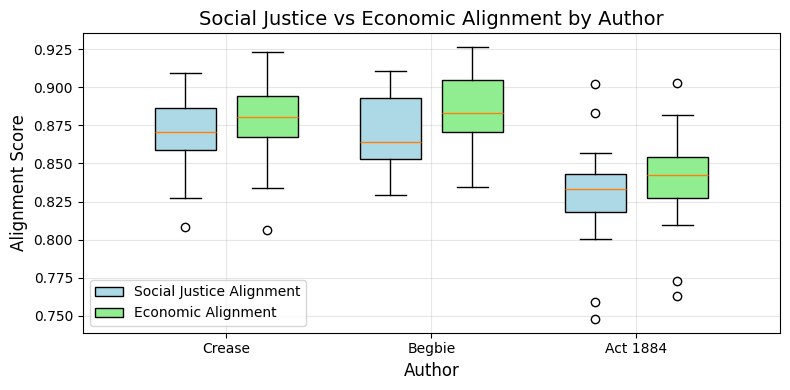

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Prepare data for boxplots
authors = alignment_df['Author'].unique()
social_justice_data = [alignment_df[alignment_df['Author'] == author]['Social Justice Alignment'].values for author in authors]
economic_data = [alignment_df[alignment_df['Author'] == author]['Economic Alignment'].values for author in authors]

n_authors = len(authors)
positions_sj = [i - 0.2 for i in range(1, n_authors + 1)]
positions_econ = [i + 0.2 for i in range(1, n_authors + 1)]

# Create boxplots
bp1 = ax.boxplot(social_justice_data, positions=positions_sj, widths=0.3, patch_artist=True, 
                 tick_labels=None, boxprops=dict(facecolor='lightblue'))
bp2 = ax.boxplot(economic_data, positions=positions_econ, widths=0.3, patch_artist=True,
                 tick_labels=None, boxprops=dict(facecolor='lightgreen'))

# Set labels
ax.set_xticks(range(1, n_authors + 1))
ax.set_xticklabels(authors)

# Add labels and title
ax.set_xlabel('Author', fontsize=12)
ax.set_ylabel('Alignment Score', fontsize=12)
ax.set_title('Social Justice vs Economic Alignment by Author', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Social Justice Alignment', 'Economic Alignment'])

plt.tight_layout()
plt.show()

### Zero-shot Stance Classification with bart-Large-mnli

We can also use the approach of **zero-shot classification** to classify the stance of Crease towards Chinese immigrants.

**Zero-shot classification** is a technique that allows us to classify text into predefined categories without the need for labeled training data. It uses a pre-trained model to generate embeddings for the text and then compares the embeddings to the predefined categories to determine the most likely category for each text. We typically have two strategies for zero-shot classification: First, tokenize by sentences and then classify each sentence individually, or second, chunk the text into overlapping windows and classify each window.

In this section, instead of using the LEGAL-BERT model, we will use the **[BART model](https://huggingface.co/facebook/bart-large-mnli)**, which is a pre-trained model that has been fine-tuned for zero-shot classification tasks. We begin by creating a dictionary to hold the full text of each author.

In [55]:
# Create the full snippets dictionary
act_1884_full = " ".join(act_1884)
crease_cases_full = " ".join(crease_cases)
begbie_cases_full = " ".join(begbie_cases)

full_cases = {"Crease": crease_cases_full, "Begbie": begbie_cases_full, "Act 1884": act_1884_full}

The first strategy we will use is to tokenize the text by sentences and then classify each sentence individually. We will use the `nltk` library to tokenize the text into sentences, and then use the BART model to classify each sentence into one of the predefined categories. Notice that we filtered out the sentences that are too short, as they may unlikely to contain meaningful stances.

In [56]:

full_snippets = {}
for author, text in full_cases.items():
    sentence = sent_tokenize(text)
    snippets = []
    for sent in sentence:
        if len(sent) > 30:  # Filter out short and meaningless sentences created by tokenization
            snippets.append(sent)
            
    full_snippets[author] = snippets

In [57]:
print("Snippet size by author:\n")
for auth, snippets in full_snippets.items():
    print(f"{auth}: {len(snippets)}")

Snippet size by author:

Crease: 287
Begbie: 202
Act 1884: 40


Here, we load the model and create a **pipeline** for zero-shot classification. The pipeline consists of the method, the model, the tokenizer and a hypothesis template that will take the text and the candidate labels as input and return the predicted labels and their corresponding scores. We also define the candidate labels that we want to use for classification, those can also be considered as "prompts" for the model to classify the text. 

The label I created are:
- "advocates for equal legal treatment of Chinese immigrants compared to white or European settlers, opposing racial discrimination"
- "describes the status or treatment of Chinese immigrants without expressing support or opposition to racial inequality",
- "justifies or reinforces unequal legal treatment of Chinese immigrants relative to white or European settlers, supporting racially discriminatory policies"

Note that the risk of using zero-shot classification is that the model may be very sensitive to the wording of the labels, so it is important to carefully design the labels to capture the intended meaning.

In [58]:
# Create pipeline for zero-shot classification
from transformers import pipeline

zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    tokenizer="facebook/bart-large-mnli",
    hypothesis_template="This legal text {}."
)

labels = [
    "advocates for equal legal treatment of Chinese immigrants compared to white or European settlers, opposing racial discrimination",
    "describes the status or treatment of Chinese immigrants without expressing support or opposition to racial inequality",
    "justifies or reinforces unequal legal treatment of Chinese immigrants relative to white or European settlers, supporting racially discriminatory policies"
]

def get_scores(snippet):
    out = zero_shot(snippet, candidate_labels=labels)
    return dict(zip(out["labels"], out["scores"]))

Device set to use cpu


We run the zero-shot classification pipeline on the tokenized sentences of the full text of each author. The pipeline will return the predicted labels and their corresponding scores for each sentence, indicating the model's confidence in each classification. We store the results in a pandas DataFrame for further analysis. 

In [59]:
# Run zero-shot classification on the snippets from the Chinese Regulation Act 1884
act_scores = {}

for auth, snippets in full_snippets.items():
    scores = []
    for snip in snippets:
        score = get_scores(snip)
        scores.append(score)
    act_scores[auth] = scores

rows = []

for auth, snippets in full_snippets.items():
    for snip, score_dict in zip(snippets, act_scores[auth]):
        row = {
            "Author": auth,
            "Text": snip,
            "Pro": score_dict[labels[0]],
            "Neutral": score_dict[labels[1]],
            "Cons": score_dict[labels[2]]
        }
        rows.append(row)

# Create DataFrame to store the scores
df_scores = pd.DataFrame(rows)

print(df_scores.head())

   Author                                               Text       Pro  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...  0.117588   
1  Crease     91, 92—“Aliens”—“Trade and Commerce”—Taxation.  0.216018   
2  Crease             On the return to a writ of certiorari.  0.421116   
3  Crease  Held, that the “Chinese Regulation Act, 1884,”...  0.089193   
4  Crease   It is an interference with the rights of Aliens.  0.176685   

    Neutral      Cons  
0  0.153374  0.729037  
1  0.428755  0.355227  
2  0.234079  0.344805  
3  0.308771  0.602036  
4  0.391968  0.431347  


We print out the top 10 sentences with the highest scores for each label, which indicates the sentences that are most likely to belong to that category.

In [ ]:
# Print out the top 10 sentences with the highest "Pro" scores
top_pro_sentences = df_scores.nlargest(10, 'Pro')

print("\nTop 10 sentences with the highest 'Pro' scores:\n")

for _, row in top_pro_sentences.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nPro Score: {row['Pro']:.4f}\n")


Top 10 sentences with the highest 'Pro' scores:
Author: Begbie
Sentence: Justices FIELD, HOFFMAN, SAWYER and DEADY and other Judges whom they cite, all confirm this, that a
State, or Provincial law imposing special disabilities or unequal burdens on Chinamen is
unconstitutional and void.
Pro Score: 0.9632

Author: Crease
Sentence: 6, ratified 26th June, 1843, p. 221, and Lord Elgin's treaty of October, 1860, authenticated copies
of which were produced in Court, secure to Chinese coming into British dominions the same "full
security for persons and property as subjects of Her Majesty."
Pro Score: 0.9309

Author: Crease
Sentence: The treaties I have quoted between Great Britain and China, binding on the Dominion and on us in
British Columbia, secure to the Chinese, just as the treaties between Great Britain and other
foreign countries secure to other foreigners, the same rights in regard to the equality of taxation
which I have described as being enjoyed by citizens of this country.
Pro

In [ ]:
# Print out the top 10 sentences with the highest "Cons" scores
top_cons_sentences = df_scores.nlargest(10, 'Cons')

print("\nTop 10 sentences with the highest 'Cons' scores:\n")

for _, row in top_cons_sentences.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nCons Score: {row['Cons']:.4f}\n")


Top 10 sentences with the highest 'Cons' scores:
Author: Crease
Sentence: And again, "A tax imposed by the law on these persons for the mere right to reside here, is an
appropriate and effective means to discourage the immigration of the Chinese into the State."
Cons Score: 0.9659

Author: Crease
Sentence: He reviewed the legislation against Chinese since confederation, contending it was levelled against
a particular race of aliens and, therefore, beyond provincial control, per *Gwynne*, J., in
*Citizens Insurance Co. v. Parsons*, 4 S. C. R., at p. 346.
Cons Score: 0.9637

Author: Crease
Sentence: The power asserted in the Act in question (the California Act) is the right of the State to
prescribe the terms upon which the Chinese shall be permitted to reside in it, and be so used as to
cut off all intercourse between them and the people of the State, and defeat the commercial policy
of the nation.
Cons Score: 0.9594

Author: Crease
Sentence: The provisions of the Act I have given some

We can also calculate the mean scores and median scores for each label across all sentences, which gives us an overall measure of the stance of each author towards Chinese immigrants.

In [62]:
# Group by author and calculate mean scores
mean_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()
median_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].median()

print("Mean scores by author:")
print(mean_scores)

print("\nMedian scores by author:")
print(median_scores)


Mean scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.291177  0.181931  0.526892
Begbie    0.288166  0.303774  0.408059
Crease    0.255667  0.283824  0.460508

Median scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.298038  0.160079  0.514868
Begbie    0.286128  0.278629  0.394753
Crease    0.254378  0.250814  0.440180


We visualize the distribution of the Pro scores and Cons scores for each author using interactive scatter plots and histograms below to see how the scores are distributed across the sentences. This allows us to see if there are any patterns or trends in the stances of the authors

In [63]:
df_scores['Text'] = df_scores['Text'].apply(lambda t: wrap_text(t, width = 50))

fig = px.scatter(
    df_scores,
    x="Pro",
    y="Cons",
    color="Author",
    hover_data=["Text"],
    title="Pros vs Cons Scores by Author",
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()

In [64]:
# Plot histogram for Pro scores (proportion)
fig_pro = px.histogram(
    df_scores,
    x="Pro",
    color="Author",
    title="Distribution of Proportion of Pro Scores by Author ",
    nbins=30,
    opacity=0.7,
    labels={"Pro": "Pro Score"},
    histnorm="probability" 
)
fig_pro.update_layout(
    xaxis_title="Pro Score",
    yaxis_title="Proportion",
    width=800,
    height=500
)
fig_pro.show()

In [65]:

# Plot histogram for Cons scores (proportion)
fig_cons = px.histogram(
    df_scores,
    x="Cons",
    color="Author",
    title="Distribution of Proportion of Cons Scores by Author",
    nbins=30,
    opacity=0.7,
    labels={"Cons": "Cons Score"},
    histnorm="probability"  
)
fig_cons.update_layout(
    xaxis_title="Cons Score",
    yaxis_title="Proportion",
    width=800,
    height=500
)
fig_cons.show()

We can also send in the full text of each author by chunking the text into overlapping windows and classify each window. Below we define the function `chunk_into_windows()` for this task. The function takes the full text, the maximum number of tokens for each window and the stride (the number of tokens to overlap between consecutive windows) as input, and returns a list of windows. 

In [66]:
# Define a function to chunk text into overlapping windows
def chunk_into_windows(text, max_tokens=512, stride=128):
    
    # Break into sentences first for cleaner boundaries
    sents = sent_tokenize(text)
    windows = []
    current = ""
    for sent in sents:
        # Tentative window if we add this sentence
        cand = current + " " + sent if current else sent
        # Count tokens
        n_tokens = len(tokenizer.encode(cand, add_special_tokens=False))
        if n_tokens <= max_tokens:
            current = cand
        else:
            # finalize current window, then start new from overlapping tail
            windows.append(current)
            # keep the stride tokens from the end of the current window
            tail_ids = tokenizer.encode(current, add_special_tokens=False)[-stride:]
            tail_text = tokenizer.decode(tail_ids)
            current = tail_text + " " + sent
    if current:
        windows.append(current)
    return windows

We chunk the full text of each author into overlapping windows and classify each window using the zero-shot classification pipeline. We also store the results in a pandas DataFrame for further analysis.

In [67]:
# Run classification per author
rows = []
for author, text in full_cases.items():
    
    windows = chunk_into_windows(text, max_tokens=256, stride=64)
    
    # classify each window
    for win in windows:
        out = zero_shot(win, candidate_labels=labels, truncation=True, max_length=256)
        # Extract scores and labels
        score_dict = dict(zip(out["labels"], out["scores"]))
        rows.append({
            "Author": author,
            "Text": win,
            "Pro": score_dict[labels[0]],
            "Neutral": score_dict[labels[1]],
            "Cons": score_dict[labels[2]]
        })

all_scores = pd.DataFrame(rows)

Here, we print out the top 5 windows with the highest "Pro" scores and the top 5 windows with the highest "Cons" scores.

In [68]:
# Print out the top 5 windows with the highest "Pro" scores
top_pro_windows = all_scores.nlargest(5, 'Pro')

print("\nTop 5 windows with the highest 'Pro' scores:\n")
for _, row in top_pro_windows.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nWindow: {wrapped_para}\nPro Score: {row['Pro']:.4f}\n")


Top 5 windows with the highest 'Pro' scores:

Author: Begbie
Window: from the constitution and the relation between the dominion and the provinces. but the judges in
those foreign courts have had a much longer and more varied experience on these topics than
ourselves ; their institutions are closely analogous in many judgment. respects, though, it is true,
contrasted in others to our own. And their opinions and reasonings being also founded on
international law, and, I take the liberty of saying, on natural equity and common sense, they are
entitled to great weight beyond the limits of their own jurisdiction. I shall only mention Lee Sing
v. Washburn, 20 Cal. Rep. 354; Baker v. Portland, 5 Law 750; Teburcio Parrott's case, coram SAWYER
and HOFFMAN, J.J., 1880, and the Quene ordinance case, coram FIELD and SAWYER, J.J., 1879; the two
latter cases published in a separate pamphlet form, in which the opinions of Mr. Justices FIELD,
HOFFMAN, SAWYER and DEADY and other Judges whom they cite

In [69]:
# Print out the top 5 windows with the highest "Cons" scores
top_cons_windows = all_scores.nlargest(5, 'Cons')

print("\nTop 5 windows with the highest 'Cons' scores:\n")
for _, row in top_cons_windows.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nWindow: {wrapped_para}\nCons Score: {row['Cons']:.4f}\n")


Top 5 windows with the highest 'Cons' scores:

Author: Crease
Window: act the legal presumption of innocence until conviction is reversed ; in every case the onus
probandi, though in a statute highly penal, is shifted from the informant on to the shoulders of the
accused, and he a foreigner not knowing one word of the law, or even the language of the accuser. In
other words, every Chinese is guilty until proved innocent—a provision which fills one conversant
with subjects with alarm; for if such a law can be tolerated as against Chinese, the precedent is
set, and in time of any popular outcry can easily be acted on for putting any other foreigners or
even special classes among ourselves, as coloured people, or French, Italians, Americans, or
Germans, under equally the same law. That certainly is interfering with aliens. The proposition that
it is a Provincial tax for revenue purposes, supposing it to be so intended under the provisions of
the Act, is so manifestly calculated to defeat

We can also calculate the mean and median scores for each author based on the results of the zero-shot classification. This gives us an overall measure of the stance of each author towards Chinese immigrants. 

In [70]:
# Calculate the mean scores and median scores for each author
mean_scores = all_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()
median_scores = all_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].median()

print("Mean scores by author:")
print(mean_scores)

print("\nMedian scores by author:")
print(median_scores)

Mean scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.289885  0.127291  0.582824
Begbie    0.329666  0.290092  0.380242
Crease    0.265891  0.206476  0.527633

Median scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.316400  0.121227  0.581850
Begbie    0.341644  0.301877  0.314771
Crease    0.239894  0.191258  0.539035


> **Discussion:**
>
> - Between the two strategies of zero-shot classification, which one do you think is more effective in capturing the stance of each author?
> - In reading the results of the zero-shot classification, do you think the model accurately captures the stance of each entity towards Chinese immigrants? 
> - What are the limitations of using zero-shot classification for this task? How can we improve the results?

### Conclusion

### Key Takeaways

### Glossary

### References

1. *Regina v. Wing Chong*, 1 B.C.R. Pt. II 150 (1885). 
2. *Wong Hoy Woon v. Duncan*, 3 B.C.R. 318 (1894). 
3. *Regina v. Mee Wah*, 3 B.C.R. 403 (1886).
4. *Regina v. Corporation of Victoria*, 1 B.C.R. Pt. II 331 (1888). 
5. *Quong Wing v. The King*, 49 S.C.R. 440 (1914). 
6. Law Society of British Columbia. (1896). *The British Columbia Reports: Being reports of cases determined in the Supreme and County Courts and in Admiralty and on appeal in the Full Court and Divisional Court* (Vol. 3). Victoria, BC: The Province Publishing Company.
7. Canada. Royal Commission on Chinese Immigration. (1885). *Report of the Royal Commission on Chinese Immigration: report and evidence*. Ottawa: Printed by order of the Commission. 
8. Thomas, P. (2012, June 12–14). Courts of last resort: The judicialization of Asian Canadian politics 1878 to 1913. Paper presented at the Annual Conference of the Canadian Political Science Association, University of Alberta, Edmonton, Canada. Retrieved from <https://cpsa-acsp.ca/papers-2012/Thomas-Paul.pdf> 
9. McLaren, J. P. S. (1991). The Early British Columbia Supreme Court and the "Chinese Question": Echoes of the rule of law. Manitoba Law Journal, 20(1), 107–147. Retrieved from <https://www.canlii.org/w/canlii/1991CanLIIDocs168.pdf> 
10. Chalkidis, I., Fergadiotis, M., Malakasiotis, P., Aletras, N., & Androutsopoulos, I. (2020). LEGAL-BERT: The Muppets straight out of Law School (arXiv:2010.02559). arXiv. <https://doi.org/10.48550/arXiv.2010.02559>
